In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from functools import reduce
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import random
random.seed(42)

In [2]:

START_YEAR = 1963
END_YEAR = 2023

dataframes = [
    pd.read_csv('Features/FEDDEBT.csv'),
    pd.read_csv('Features/FORINV.csv'),
    pd.read_csv('Features/GINI.csv'),
    pd.read_csv('Features/HCI.csv'),
    pd.read_csv('Features/INFLATION.csv'),
    pd.read_csv('Features/INTRATE.csv'),
    pd.read_csv('Features/ITAX.csv'),
    pd.read_csv('Features/PCNTWGGRWTH.csv'),
    pd.read_csv('Features/RCONSPEND.csv'),
    pd.read_csv('Features/RGDP.csv'),
    pd.read_csv('Features/RLESTMRKTVAL.csv'),
    pd.read_csv('Features/RMEDEARN.csv'),
    pd.read_csv('Features/RMEDHOUINC.csv'),
    pd.read_csv('Features/UNRATE.csv')
]

merged_df = reduce(lambda left, right: pd.merge(left, right, on='DATE', how='left'), dataframes)
new_columns = ['DATE', 'FEDERAL DEBT', 'FOREIGN INVESTMENT', 'GINI', 'HUMAN CAPITAL INDEX', 'INFLATION', 'INTEREST RATE', 'HIGHEST INCOME TAX', 'PERCENT WAGE GROWTH', 'RCONSPEND', 'REAL GDP', 'REAL ESTATE MARKET VAL', 'RMEDEARN', 'RMEDHOUINC', 'UNEMPLOYMENT RATE']
merged_df.columns = new_columns

# Replace xxxx-xx-xx Date format to Year--only keep one row per year
merged_df = merged_df[merged_df['GINI'].notna()]
merged_df['DATE'] = pd.to_datetime(merged_df['DATE'])
merged_df['YEAR'] = merged_df['DATE'].dt.year
merged_df = merged_df.drop(columns = ['DATE'])
merged_df = merged_df.drop_duplicates(subset='YEAR', keep='first')

# Interpolate missing values
merged_df = merged_df.bfill().ffill()

merged_df.to_csv('merged_df.csv', index=False)

In [3]:
data = pd.read_csv('merged_df.csv')

features = data.drop(['YEAR', 'GINI'], axis=1)  # Select features
target = data['GINI']  # Select Label

input_size = len(new_columns) - 2  # -2 from Year and Gini columns
output_size = 1
learning_rate = 0.001
batch_size = 64
num_epochs = 5000

g = torch.Generator()
g.manual_seed(42)

X_train, X_temp, y_train, y_temp = train_test_split(
    features, target, test_size=0.4, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), 
                           torch.tensor(y_val.values, dtype=torch.float32))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, generator=g)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, generator=g)

class RegressionNN(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, 128) 
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(128, 64)  
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(0.1)
        self.fc4 = nn.Linear(64, 1)

        
        # Initialize weights
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.fc1(x))) 
        x = self.dropout1(x)
        x = F.leaky_relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = F.leaky_relu_(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        return self.fc4(x)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

model = RegressionNN(input_size=input_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [4]:
# Training
losses = []
val_losses = []
best_loss = float('inf')  # Initialize with a large value
patience = 100  # Set the patience parameter
trigger_times = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device=device)
        targets = targets.to(device=device)

        scores = model(data)
        loss = criterion(scores, targets.view(-1, 1))  # Reshape targets for MSELoss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    losses.append(average_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, targets in val_loader:
            data = data.to(device)
            targets = targets.to(device)
            scores = model(data)
            val_loss += criterion(scores, targets.view(-1, 1)).item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)  # 


    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        trigger_times = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break  # Stop training

    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}')

Epoch [500/5000], Loss: 50.6120
Epoch [1000/5000], Loss: 4.2639
Early stopping at epoch 1429


In [5]:
model.eval()
test_predictions = []
test_loss = 0

with torch.no_grad():
    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)
        scores = model(data)
        loss = criterion(scores, targets.view(-1, 1))
        test_loss += loss.item()
        test_predictions.extend(scores.cpu().numpy())

# Flatten predictions to match y_test shape
test_predictions = np.array(test_predictions).flatten()

In [6]:
# Regression metrics
mae = mean_absolute_error(y_test.values, test_predictions)
r2 = r2_score(y_test.values, test_predictions)

print(f'Test Loss: {test_loss / len(test_loader):.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'R-squared (R2): {r2:.4f}')

Test Loss: 0.8939
Mean Absolute Error (MAE): 0.7405
R-squared (R2): 0.7851


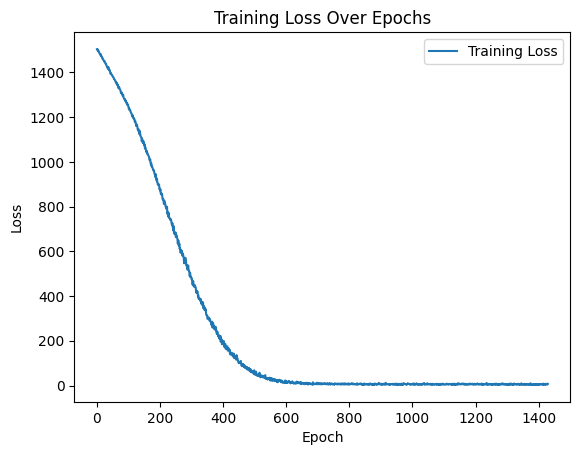

In [7]:
# Plotting
plt.plot(range(1, epoch + 2), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

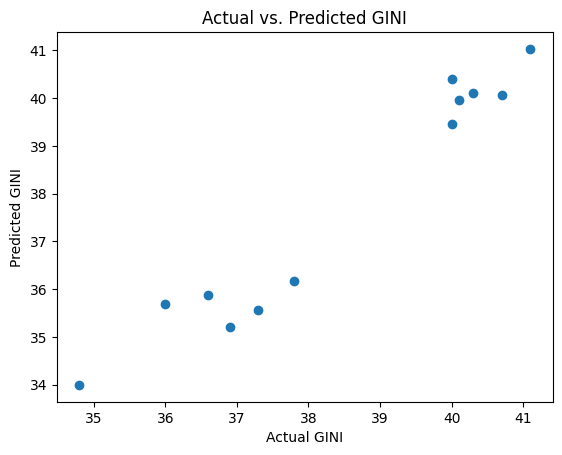

In [8]:
plt.scatter(y_test, test_predictions, alpha=1)
plt.xlabel('Actual GINI')
plt.ylabel('Predicted GINI')
plt.title('Actual vs. Predicted GINI')
plt.show()

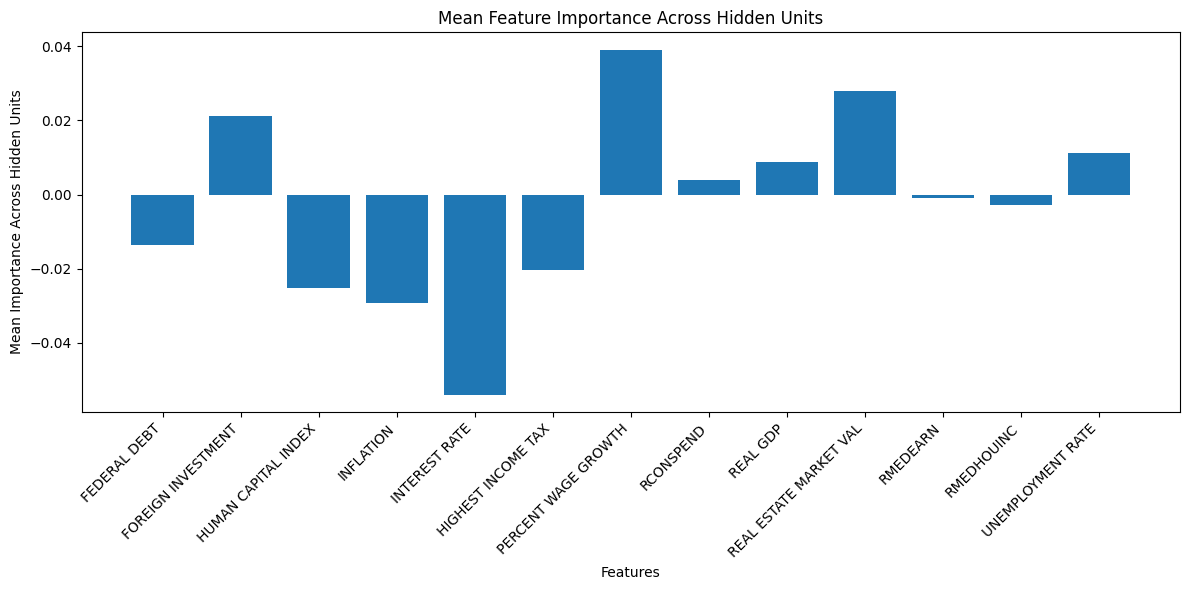

In [9]:
# Feature Importance Visualization:
weights_fc1 = model.fc1.weight.detach().numpy()

# Compute mean importance across hidden units for each feature
feature_importance_mean = weights_fc1.mean(axis=0)

plt.figure(figsize=(12, 6))

plt.bar(range(len(feature_importance_mean)), feature_importance_mean)
plt.xlabel('Features')
plt.ylabel('Mean Importance Across Hidden Units')
plt.title('Mean Feature Importance Across Hidden Units')
plt.xticks(range(len(features.columns)), features.columns, rotation=45, ha='right')

plt.tight_layout()
plt.show()

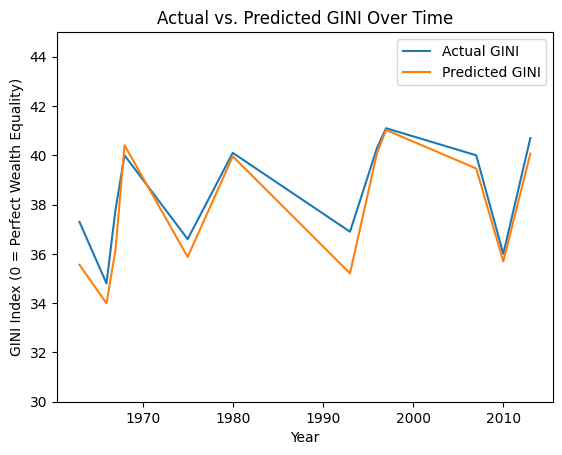

In [10]:
# Plotting time series data

y_test_sorted = y_test.sort_index()

plt.plot(y_test_sorted.index+START_YEAR, y_test, label='Actual GINI')
plt.plot(y_test_sorted.index+START_YEAR, test_predictions, label='Predicted GINI')
plt.xlabel('Year')
plt.ylabel('GINI Index (0 = Perfect Wealth Equality)')
plt.ylim(30,45)
plt.title('Actual vs. Predicted GINI Over Time')
plt.legend()
plt.show()